# [PG01] Unsupervised anomaly detection in industrial image data with autoencoders

In this notebook we are going to develop the final projet for the EAI course held by Christian Napoli.

## Imports & Download

In [62]:
# install the requirements
%pip install -r requirements.txt > /dev/null
# set to false if you already have the dataset
download_dataset = False 
if download_dataset:
    %cd dataset
    !bash dataset/download_dataset.sh
    %cd ..

Note: you may need to restart the kernel to use updated packages.


In [55]:
import dataclasses
from src.data_module import MVTec_Dataset, MVTec_DataModule
from dataclasses import dataclass
from dataclasses import asdict
import matplotlib.pyplot as plt
import torchvision

## Dataset test

Just to have a visual feedback and test our code, we plot some samples from the training set (only not anomalous samples) and test set (normal and anomalous)

In [63]:
@dataclass
class Hparams:
    img_size: int = 64  # size of image
    batch_size: int = 256  # size of the batches
    n_cpu: int = 8  # number of cpu threads to use for the dataloaders
    latent_dim: int = 128 # size of autoencoder latent space
hparams = asdict(Hparams())

In [64]:
dataset_dir = "dataset/mvtec_anomaly_detection"
MVTec_Data = MVTec_DataModule(hparams, dataset_dir)
# to setup it takes ~2.5 minutes
MVTec_Data.setup()

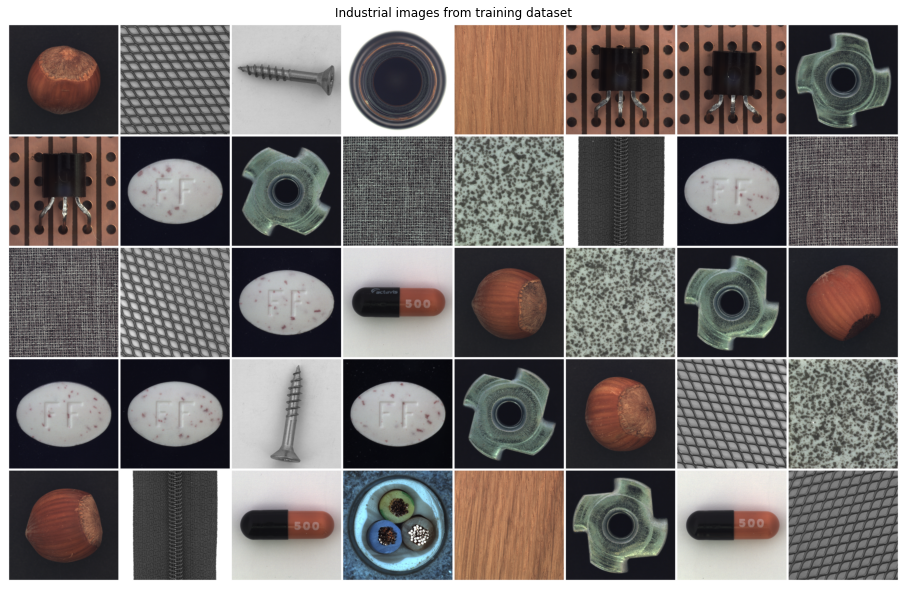

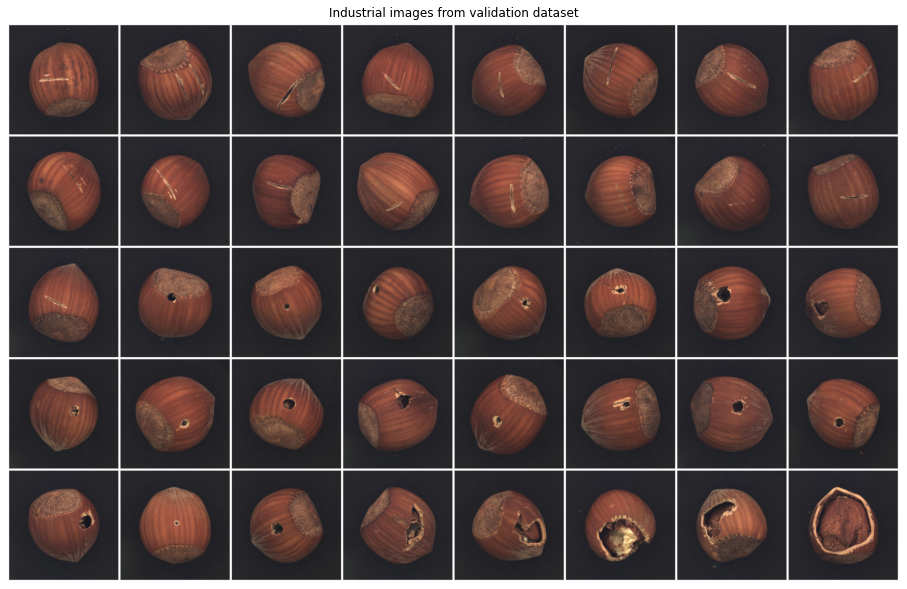

In [65]:
# to make sure everything works we just plot a sample of our images
def plot_objects(images, 
                images_per_row, 
                border = 10, 
                pad_value = 1,
                title = 'Industrial images',
                figsize = (16,16)):
    plt.figure(figsize = figsize)
    plt.imshow(torchvision.utils.make_grid(images,images_per_row,border,pad_value=pad_value).permute(1, 2, 0))
    plt.title(title)
    plt.axis('off')

batch = iter(MVTec_Data.train_dataloader()).next()
plot_objects(batch["img"][0:40], images_per_row=8, title="Industrial images from training dataset")
batch2 = iter(MVTec_Data.val_dataloader()).next()
plot_objects(batch2["img"][0:40], images_per_row=8, title="Industrial images from validation dataset")